# Mouse Peripheral Blood from the Mouse Cell Atlas - sample 1

Here we analyse the first sample of PB from the MCA datasets (Microwell-seq Protocol). We downloaded the DGE matrix labelled 'MCA_500more_dge' which contains cells with more than 500 transcripts. The batch genes were not removed.
Link to the dataset: https://figshare.com/articles/MCA_DGE_Data/5435866

In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4+40.gbd5f862 anndata==0.6.22.post1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [4]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/MCApb_1.h5ad'  # the file that will store the analysis results

In [5]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)

In [6]:
## Load previously processed dataset
#adata = sc.read_h5ad(results_file)
#adata.obs.index.names = ['barcode']

In [6]:
# Set up data loading
file = '../../../Munich/datasets/mouse/MCA_PB/PeripheralBlood1_dge.txt.gz'
adata = sc.read(filename=file, cache=True)
adata = adata.transpose()

... writing an h5ad cache file to speedup reading next time


In [7]:
adata

AnnData object with n_obs × n_vars = 324 × 14299 

In [8]:
adata.var.head()

""
0610007P14Rik
0610009B22Rik
0610009L18Rik
0610009O20Rik
0610010F05Rik


In [9]:
adata.var.index.names = ['gene_symbol']
adata.var.head()

""
gene_symbol
0610007P14Rik
0610009B22Rik
0610009L18Rik
0610009O20Rik
0610010F05Rik


In [10]:
adata.obs.head()

""
PeripheralBlood_1.CGCACCAGTTTAGTGGTA
PeripheralBlood_1.GGACATCATCCCATGCTT
PeripheralBlood_1.ACAATAGGTACAGAGATC
PeripheralBlood_1.CTGTGTACCTGAGGTACA
PeripheralBlood_1.TGATCATAGAGAATCTCT


In [12]:
adata.obs.index.names = ['barcode']
adata.obs.head()

""
barcode
PeripheralBlood_1.CGCACCAGTTTAGTGGTA
PeripheralBlood_1.GGACATCATCCCATGCTT
PeripheralBlood_1.ACAATAGGTACAGAGATC
PeripheralBlood_1.CTGTGTACCTGAGGTACA
PeripheralBlood_1.TGATCATAGAGAATCTCT


In [13]:
adata.var_names_make_unique()

In [14]:
# Checking the total size of the data set
adata.shape

(324, 14299)

# 1. Pre-processing and visualization

## 1.1 Quality control

In [15]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [16]:
mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


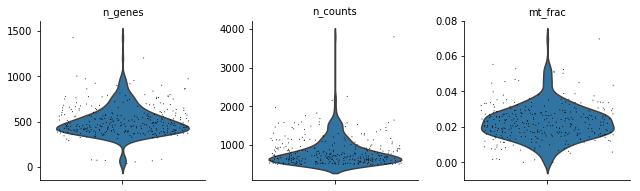

In [17]:
# Quality control - plot QC metrics
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

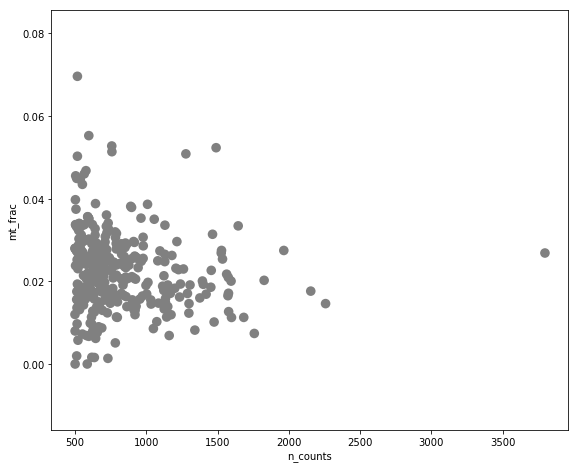

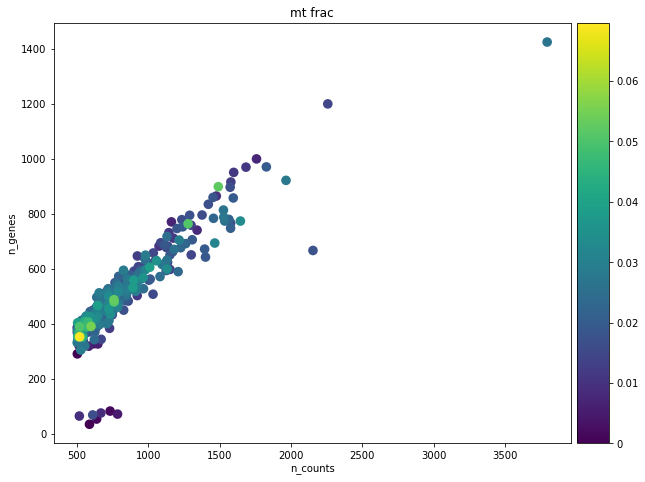

In [18]:
sc.pl.scatter(adata, x='n_counts', y='mt_frac')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

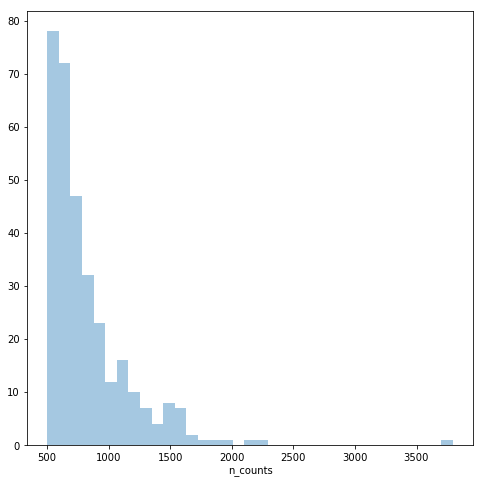

In [19]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

The histogram of the number of counts per cell show that there's a smaller group of cells with n_counts > 2000 which are standing apart from the main population. 

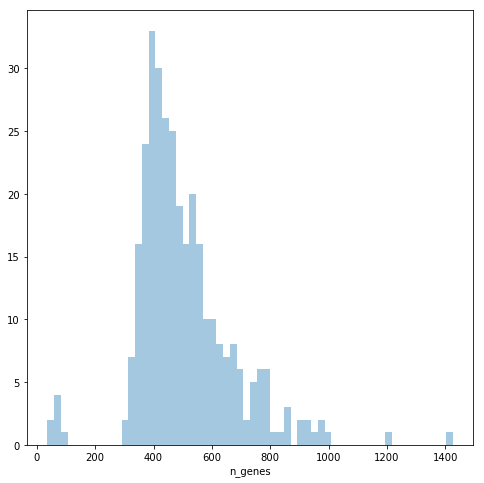

In [20]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

From the histogram of number of genes, we can exclude the small population with n_genes < 200.
No need to threshold on mt_frac.

In [21]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 2000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_genes = 200)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 324
filtered out 3 cells that havemore than 2000 counts
Number of cells after max count filter: 321
filtered out 7 cells that haveless than 200 genes expressed
Number of cells after gene filter: 314


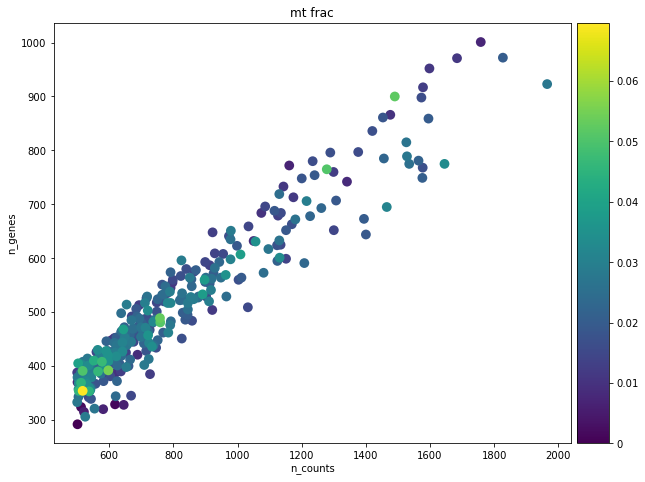

In [22]:
# look at the effect of thresholding
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

In [23]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=5)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 14299
filtered out 8174 genes that are detectedin less than 5 cells
Number of genes after cell filter: 6125


## 1.2 Normalization

In [24]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 4 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [25]:
# Check if the minimum number of cells per cluster is < 21:in that case, sizes will be also passed as input to the normalization
adata_pp.obs['groups'].value_counts()

0    158
1     96
2     44
3     16
Name: groups, dtype: int64

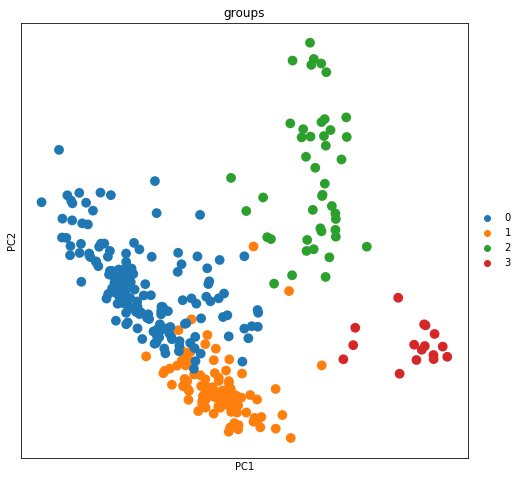

In [26]:
# Check that the smallest cluster (which is < 21) doesn't show any problem
sc.pl.pca_scatter(adata_pp, color='groups')

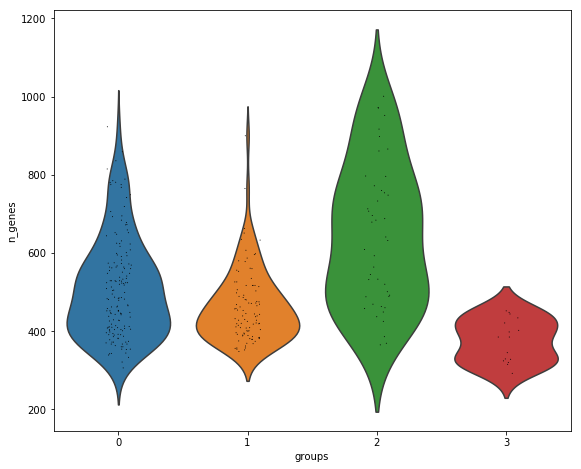

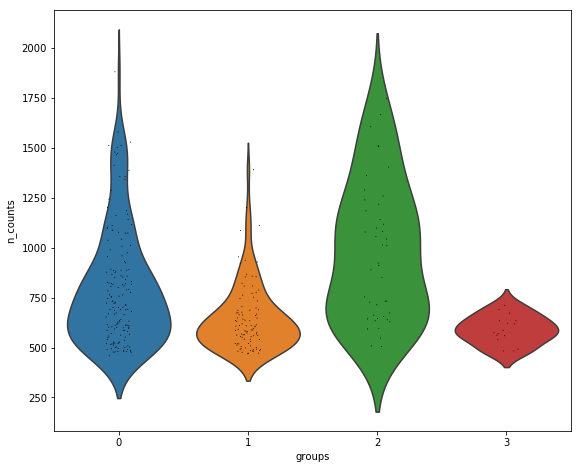

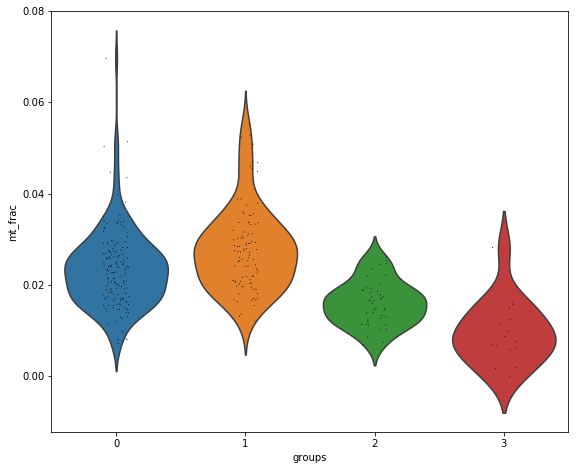

In [27]:
sc.pl.violin(adata_pp, 'n_genes', groupby= 'groups')
sc.pl.violin(adata_pp, 'n_counts', groupby= 'groups')
sc.pl.violin(adata_pp, 'mt_frac', groupby= 'groups')

In [28]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [29]:
# Having the smallest cluster size = 16 we need to pass sizes as input
sizes = input_groups.value_counts()

In [30]:
%%R -i data_mat -i input_groups -i sizes -o size_factors

size_factors = computeSumFactors(data_mat, sizes = sizes, clusters=input_groups, min.mean=0.1)

In [31]:
#Delete adata_pp
del adata_pp

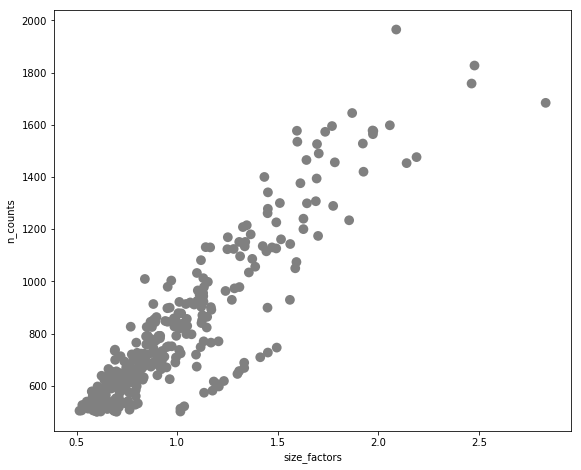

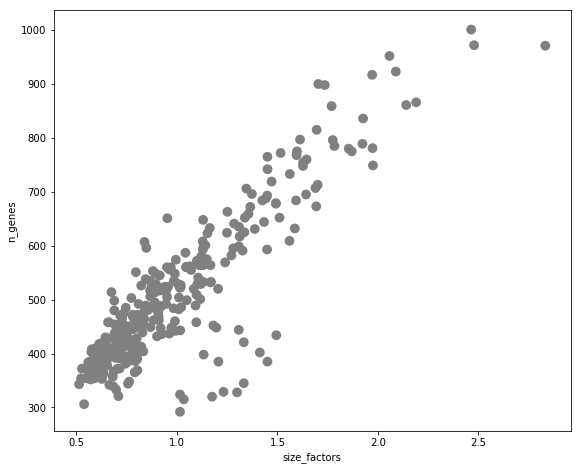

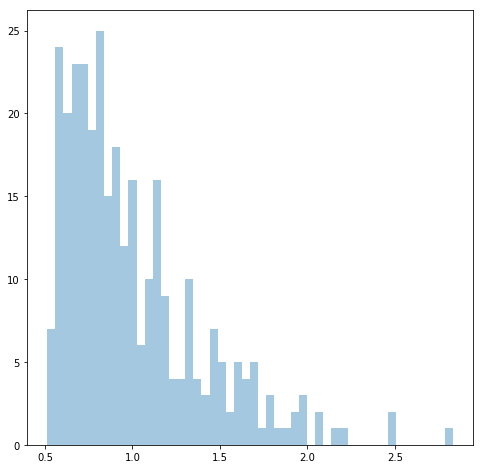

In [32]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [33]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [34]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [35]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 1.3 Highly variable genes

In [36]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3999


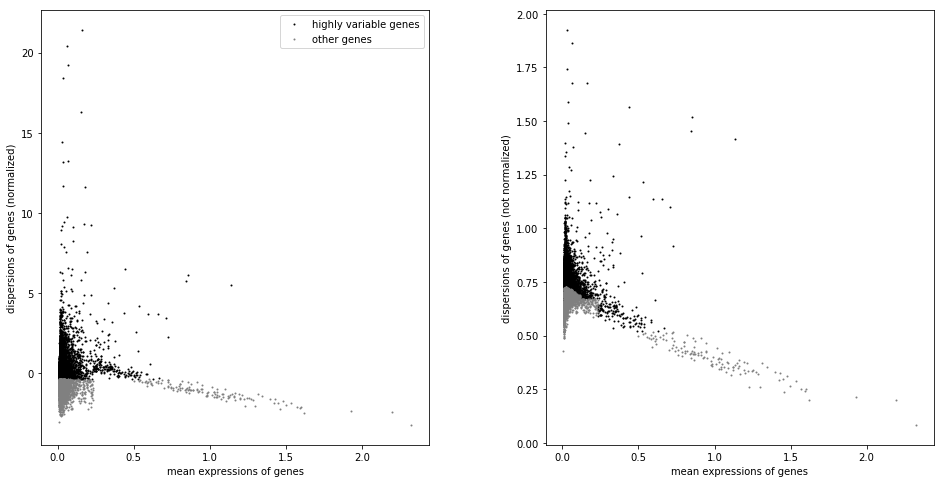

In [37]:
sc.pl.highly_variable_genes(adata)

# 2. Visualization

In [38]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [ 1.          0.98876     0.9693348   0.9504467   0.8573632   0.7800268
      0.7083814   0.63612324  0.62233657  0.61687714  0.60603696  0.59006447
      0.57521296 -0.591402   -0.6208529 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:01)

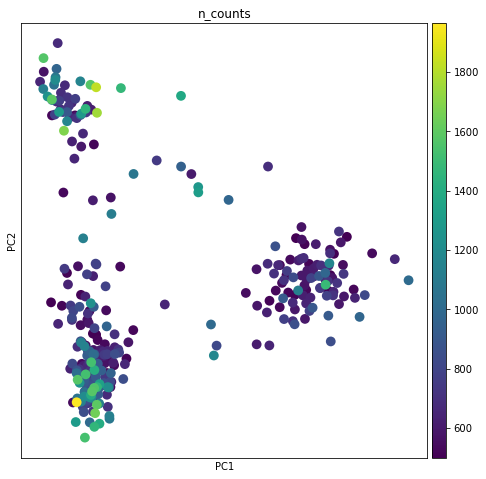

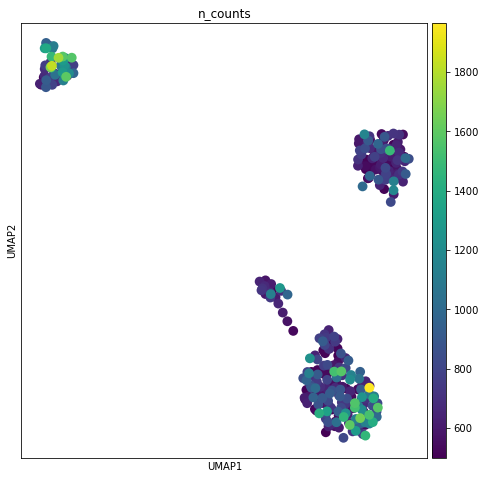

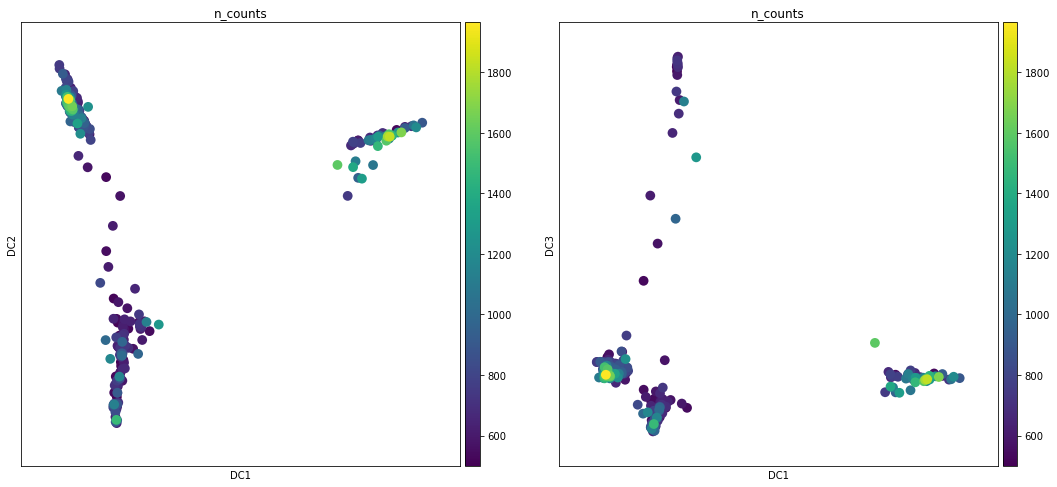

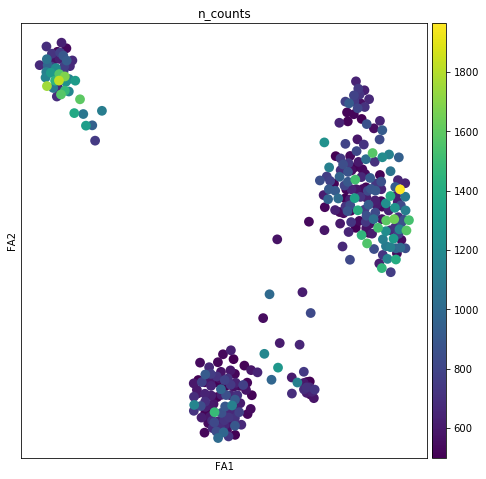

In [39]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

In [40]:
adata.write(results_file)

# 3. Clustering

In [41]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)


In [42]:
adata.obs['louvain_r1'].value_counts()

0    131
1     94
2     44
3     25
4     20
Name: louvain_r1, dtype: int64

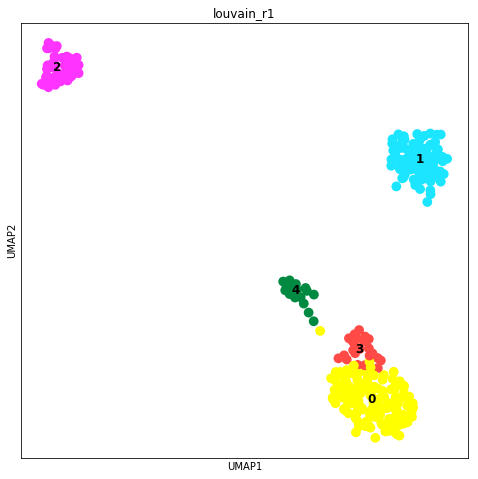

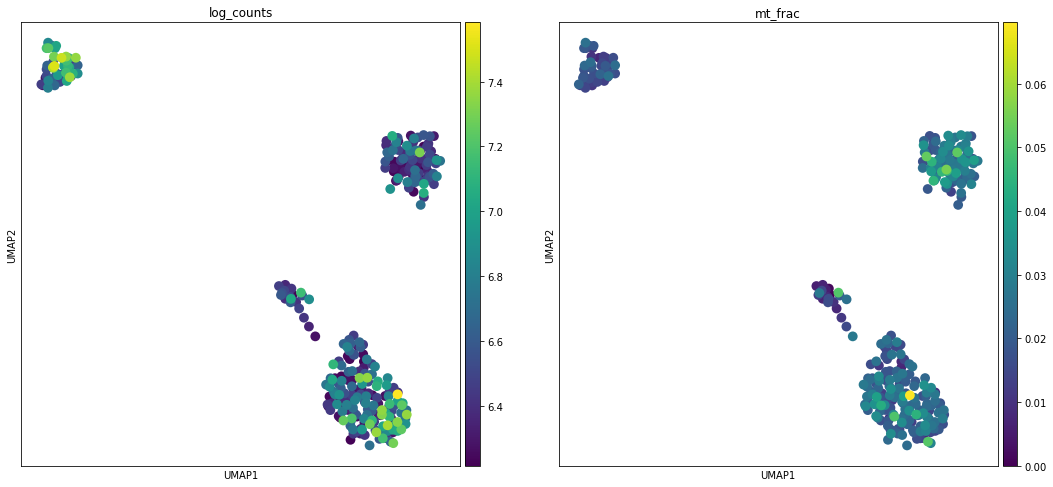

In [43]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1'], palette=sc.pl.palettes.default_64, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])



# 4. MCA cell type classification
Here we want to annotate the cells with the published classification from the Mouse Cell Atlas. We downloaded the cell annotations from this link. This would serve us as a reference map to identify cell types that share the same markers genes as the one identified for human samples.

In [44]:
mca_class = pd.read_csv('../../../Munich/datasets/mouse/MCA_CellAssignments.csv')
mca_class.head()

,Unnamed: 0,Cell.name,ClusterID,Tissue,Batch,Cell.Barcode,Annotation
0,1,Bladder_1.AAAACGAAAACGGGGCGA,Bladder_1,Bladder,Bladder_1,AAAACGAAAACGGGGCGA,Stromal cell_Dpt high(Bladder)
1,2,Bladder_1.AAAACGAAGCGGCCGCTA,Bladder_5,Bladder,Bladder_1,AAAACGAAGCGGCCGCTA,Stromal cell_Car3 high(Bladder)
2,3,Bladder_1.AAAACGAAGTACTAGCAT,Bladder_16,Bladder,Bladder_1,AAAACGAAGTACTAGCAT,Vascular smooth muscle progenitor cell(Bladder)
3,4,Bladder_1.AAAACGACGTTGCTGTGT,Bladder_8,Bladder,Bladder_1,AAAACGACGTTGCTGTGT,Vascular endothelial cell(Bladder)
4,5,Bladder_1.AAAACGAGCGAGCGAGTA,Bladder_4,Bladder,Bladder_1,AAAACGAGCGAGCGAGTA,Urothelium(Bladder)


In [46]:
# Select only tissue of interest
PB_class = mca_class[mca_class['Tissue'] == 'Peripheral_Blood']
PB_class.shape

(7095, 7)

In [47]:
# Prepare the data to be merged to adata.obs, to match the annotation with the correct barcode
pb_df = PB_class[['Cell.name', 'Annotation']].rename(columns = {'Cell.name':'barcode', 'Annotation':'MCA_annotation'})
pb_df['MCA_annotation'] = [i.split('(')[0] for i in pb_df['MCA_annotation']]
pb_df.head()

,barcode,MCA_annotation
161686,PeripheralBlood_1.AAAACGTGTCACGCCCTC,T cell_Gm14303 high
161687,PeripheralBlood_1.AAAGTTAAAACGTCGGGT,T cell_Gm14303 high
161688,PeripheralBlood_1.AAAGTTACGTTGCTGAAA,T cell_Gm14303 high
161689,PeripheralBlood_1.AAAGTTGTCCCGGGACAT,T cell_Gm14303 high
161690,PeripheralBlood_1.AACCTAAAGCGGATCAAC,B cell_Rps27rt high


In [48]:
# save adata.obs as a dataframe and make barcodes column accessible
adata_df = adata.obs.reset_index()
adata_df.head()

,barcode,n_counts,log_counts,n_genes,mt_frac,size_factors,louvain_r1
0,PeripheralBlood_1.CTGTGTACCTGAGGTACA,1758.0,7.471932,1001,0.007395,2.464080,2
1,PeripheralBlood_1.TGATCATAGAGAATCTCT,1965.0,7.583248,923,0.027481,2.089148,0
2,PeripheralBlood_1.AGGACTGGTACAAATAAA,1684.0,7.428927,971,0.011283,2.832706,2
3,PeripheralBlood_1.GAATTAACACCCCCGACG,1453.0,7.281385,861,0.018582,2.140793,2
4,PeripheralBlood_1.TTCATAGGCTGCCCAGAC,1827.0,7.510430,972,0.020252,2.478567,2


In [49]:
# merge the two dataframes
adata_merge = adata_df.merge(pb_df, how='left', on='barcode')
adata_merge.head()

,barcode,n_counts,log_counts,n_genes,mt_frac,size_factors,louvain_r1,MCA_annotation
0,PeripheralBlood_1.CTGTGTACCTGAGGTACA,1758.0,7.471932,1001,0.007395,2.464080,2,Macrophage_Flt-ps1 high
1,PeripheralBlood_1.TGATCATAGAGAATCTCT,1965.0,7.583248,923,0.027481,2.089148,0,T cell_Gm14303 high
2,PeripheralBlood_1.AGGACTGGTACAAATAAA,1684.0,7.428927,971,0.011283,2.832706,2,Macrophage_Flt-ps1 high
3,PeripheralBlood_1.GAATTAACACCCCCGACG,1453.0,7.281385,861,0.018582,2.140793,2,Macrophage_Flt-ps1 high
4,PeripheralBlood_1.TTCATAGGCTGCCCAGAC,1827.0,7.510430,972,0.020252,2.478567,2,Macrophage_Flt-ps1 high


In [50]:
# reassign merged dataframe as adata.obs
adata_merge.set_index('barcode', inplace = True)
adata.obs = adata_merge

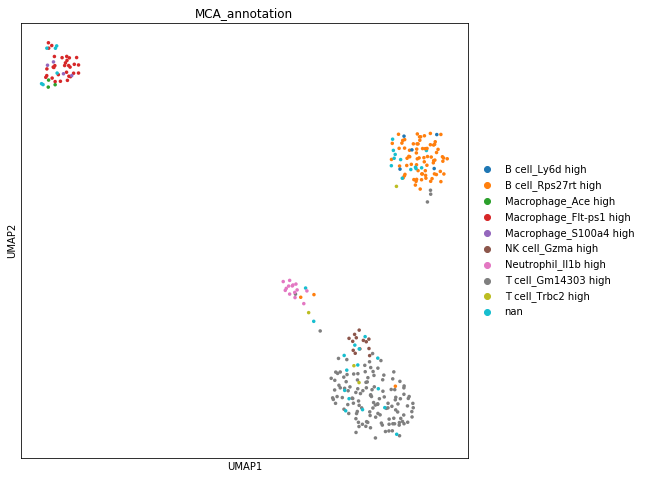

In [55]:
sc.pl.umap(adata, color='MCA_annotation', size= 50)

# 5. Plot makers of cell types

In [56]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## T cells
We want to annotate CD8+ versus CD4+ cells.

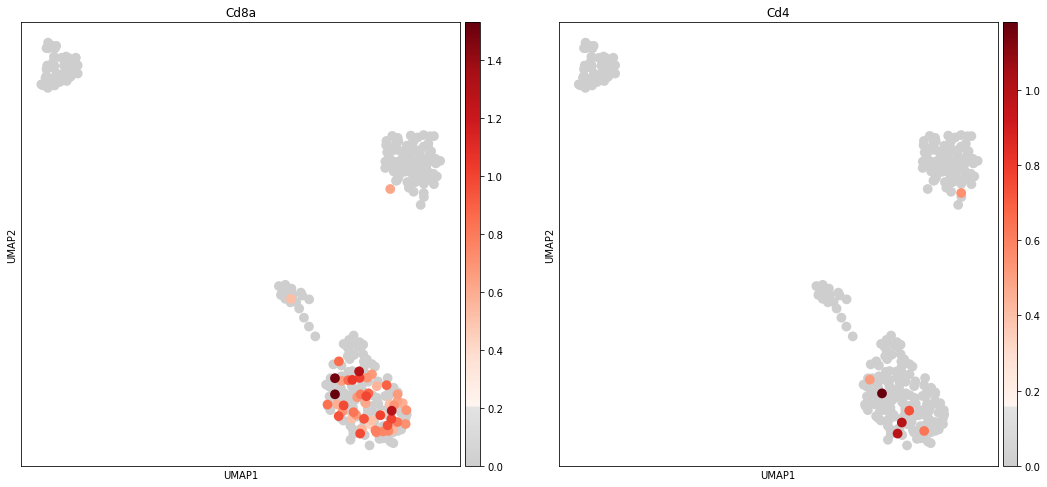

In [58]:
#Canonical markers Cd8b not present
sc.pl.umap(adata, color=['Cd8a', 'Cd4'], use_raw=False, color_map=mymap)

Cluster 0 is CD8+ T cells, there are no (or few) CD4+ T cells.

### Natural killer T cells and NK cells
We consider NK cells as CD8- CD4-. NKT cells are instead CD8+/CD4+ and NKG7/GZMA +.

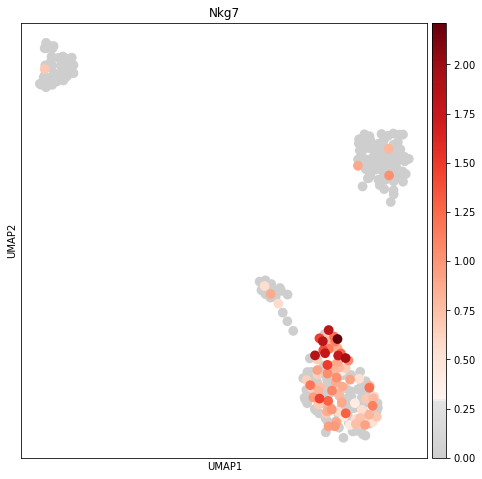

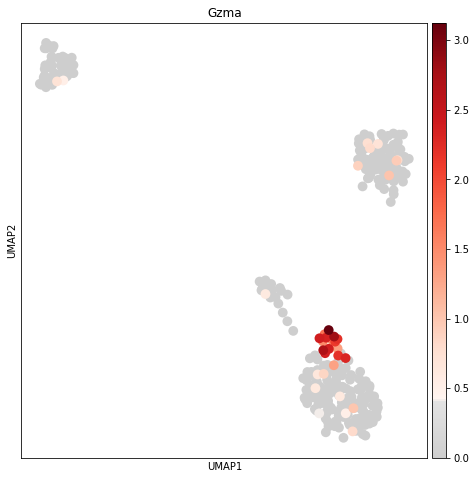

In [61]:
sc.pl.umap(adata, color=['Nkg7'], use_raw=False, color_map=mymap)
sc.pl.umap(adata, color=['Gzma'], use_raw=False, color_map=mymap)

Cluster 3 is NK cells

## Monocytes: CD14+ and CD16+

Monocytes markers are not present in the data.

In [63]:
##sc.pl.umap(adata, color=['Fcgr3a','Cd14'], use_raw=False, color_map=mymap)

## Monocyte-derived Dendritic cells
Markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

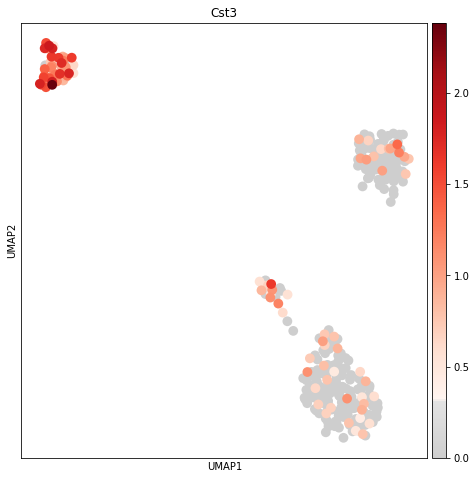

In [74]:
sc.pl.umap(adata, color=['Cst3'], use_raw=False, color_map=mymap)

Comparing the expression of the only marker present with the human data, we conclude that cluster 2 is monocytes. 

## B cells
Oetjen et al. annotates B cells as CD20+ (MS4A1) or CD10+ (MME).

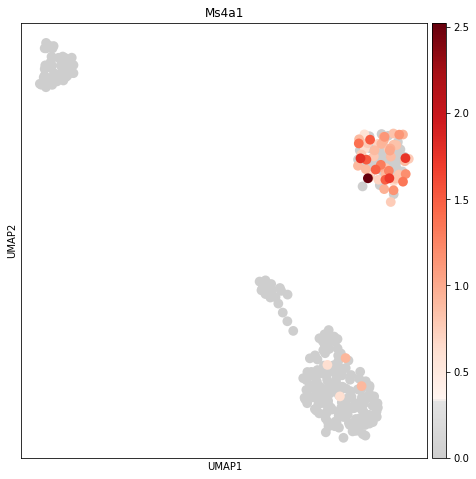

In [72]:
# Mme not there
sc.pl.umap(adata, color=['Ms4a1'], use_raw=False, color_map=mymap)

Cluter 1 is B cells. 

# 7. Final cell-type annotation

In [75]:
# Categories to rename
adata.obs['final_annotation'] = adata.obs['louvain_r1']
adata.rename_categories('final_annotation', ['CD8+ T cells', 
                                             'CD20+ B cells', 
                                             'Monocytes',
                                             'NK cells', 
                                             'Neutrophils'])

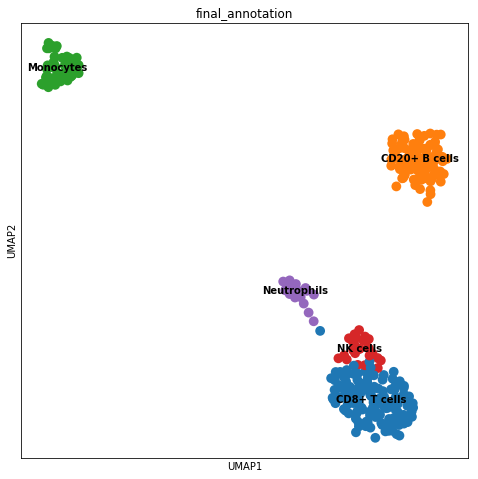

In [76]:
sc.pl.umap(adata, color='final_annotation', legend_loc='on data')

In [77]:
# save final result
adata.write(results_file)